In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
from scipy import sparse

from sklearn import preprocessing
from sklearn.decomposition import PCA

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [5]:
%%time
# load in 5890 by 1.2e6 SNP matrix
sparse_x_all = sparse.load_npz("/scratch/users/velina/sparse_nn/eqtl_sparse_all.npz")

CPU times: user 2min 28s, sys: 20.7 s, total: 2min 49s
Wall time: 2min 49s


In [6]:
# Load in sample metadata
df_als_metadata = pd.read_csv('/scratch/users/velina/dml/metadata_5890_inds.csv', index_col=0)

In [7]:
df_als_metadata.source.value_counts()

NYGC    3386
1KG     2504
Name: source, dtype: int64

# Subsetting SNPs

In [8]:
%%time

# First impute missing values with 0s for now
sparse_x_all[sparse_x_all == -1] = 0

CPU times: user 6min 42s, sys: 8.18 s, total: 6min 50s
Wall time: 6min 50s


In [9]:
%%time
# get frequencies for all alleles 
freqs = np.sum(sparse_x_all, axis=0) / (2*sparse_x_all.shape[0])

CPU times: user 18.9 s, sys: 8.88 ms, total: 18.9 s
Wall time: 19 s


CPU times: user 75.7 ms, sys: 6.93 ms, total: 82.7 ms
Wall time: 140 ms


Text(0, 0.5, 'Counts')

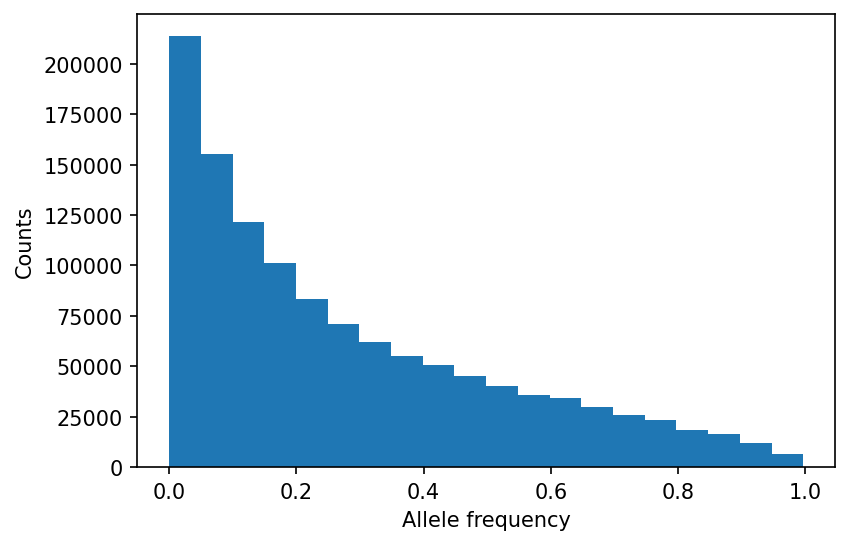

In [10]:
%%time
# Plot frequencies
plt.hist(np.array(freqs)[0], bins=20)
plt.xlabel('Allele frequency')
plt.ylabel('Counts')

In [11]:
# How many SNPs do we want to retain?
subset_size = 100000

def sparse_var(a, axis=None):
    """ Variance of sparse matrix a
    var = mean(a**2) - mean(a)**2
    """
    a_squared = a.copy()
    a_squared.data **= 2
    return a_squared.mean(axis) - np.square(a.mean(axis))

In [12]:
%%time

# get most variable SNP positions 
top_var = np.argsort(-1*np.asarray(sparse_var(sparse_x_all, axis=0)).flatten())[:subset_size]

CPU times: user 2min 47s, sys: 1min 11s, total: 3min 59s
Wall time: 4min


In [13]:
# Get indices of SNPs with reasonable frequencies
# Using minor allele freq. > 0.05
valid_inds = np.where((np.array(freqs)[0] > 0.05) & (np.array(freqs)[0] < 0.95))[0]

# Running PCA

In [14]:
def compute_pcs_with_covar(snp_mat, meta_df, meta_columns=None, standardize=True, n_components=20):
    """
    Function to compute PCA on SNP matrix and add metadata columns to resulting PC component matrix.
    
    Arguments:
        snp_mat: n_inds x n_snp np array
        meta_df: Dataframe of metadata. Row index must correspond to rows of snp_mat
        meta_columns: List of column names to include in final dataframe
    
    Returns:
        snp_pca: PCA object fit to snp_mat data
        df_snp_pca: Dataframe consisting of principal components and chosen metadata columns (n x n_components + len(covar_columns))
    """
    # Standardize the data before performing PCA
    if standardize:
        df_snp_std = preprocessing.StandardScaler().fit_transform(snp_mat)  
    else:
        df_snp_std = snp_mat

    # Perform the PCA and transform the data
    snp_pca = PCA(n_components=n_components, svd_solver = 'arpack', random_state = 1)

    np_snp_pca = snp_pca.fit_transform(df_snp_std)
    df_snp_pca = pd.DataFrame(np_snp_pca, columns = ['PC' + str(x) for x in range(1, n_components + 1)])

    if meta_columns is None:
        meta_columns = meta_df.columns
    
    # add appropriate metadata
    for col in meta_columns:
        df_snp_pca[col] = meta_df[col].values
        
    return snp_pca, df_snp_pca

## 1KG PCA and visualization

In [18]:
%%time

# Compute PCA for relevant pairs of subpopulations in the 1KG dataset
# CEU and LWK, or CEU and GIH, or CEU and ASW
subpop_pairs = [['CEU', 'LWK'], ['CEU', 'GIH'],
                ['CEU', 'ASW']]

# Generate 3 random sets of SNPs for each pairing
pca_results = {}

for subpops in subpop_pairs:
    df_als_metadata_poppairs = df_als_metadata[df_als_metadata.Population.isin(subpops)]
    
    for seed in range(3):
        np.random.seed(seed)
        inds_s = np.random.choice(valid_inds, size=subset_size, replace=False)

        # Subset sparse matrix
        sparse_x_sub = sparse_x_all[:, inds_s]
        sparse_x_sub = sparse_x_sub[df_als_metadata_poppairs.ind_val.values, :]
        print(sparse_x_sub.shape)
        
        pca_results[f'{"-".join(subpops)}_{seed}'] = compute_pcs_with_covar(sparse_x_sub.toarray(),
                                                                            df_als_metadata_poppairs,
                                                                            meta_columns = ['Population',
                                                                                            'super_pop'])

(198, 100000)
(198, 100000)
(198, 100000)
(202, 100000)
(202, 100000)
(202, 100000)
(160, 100000)
(160, 100000)
(160, 100000)
CPU times: user 11min 33s, sys: 2min 11s, total: 13min 44s
Wall time: 3min 39s


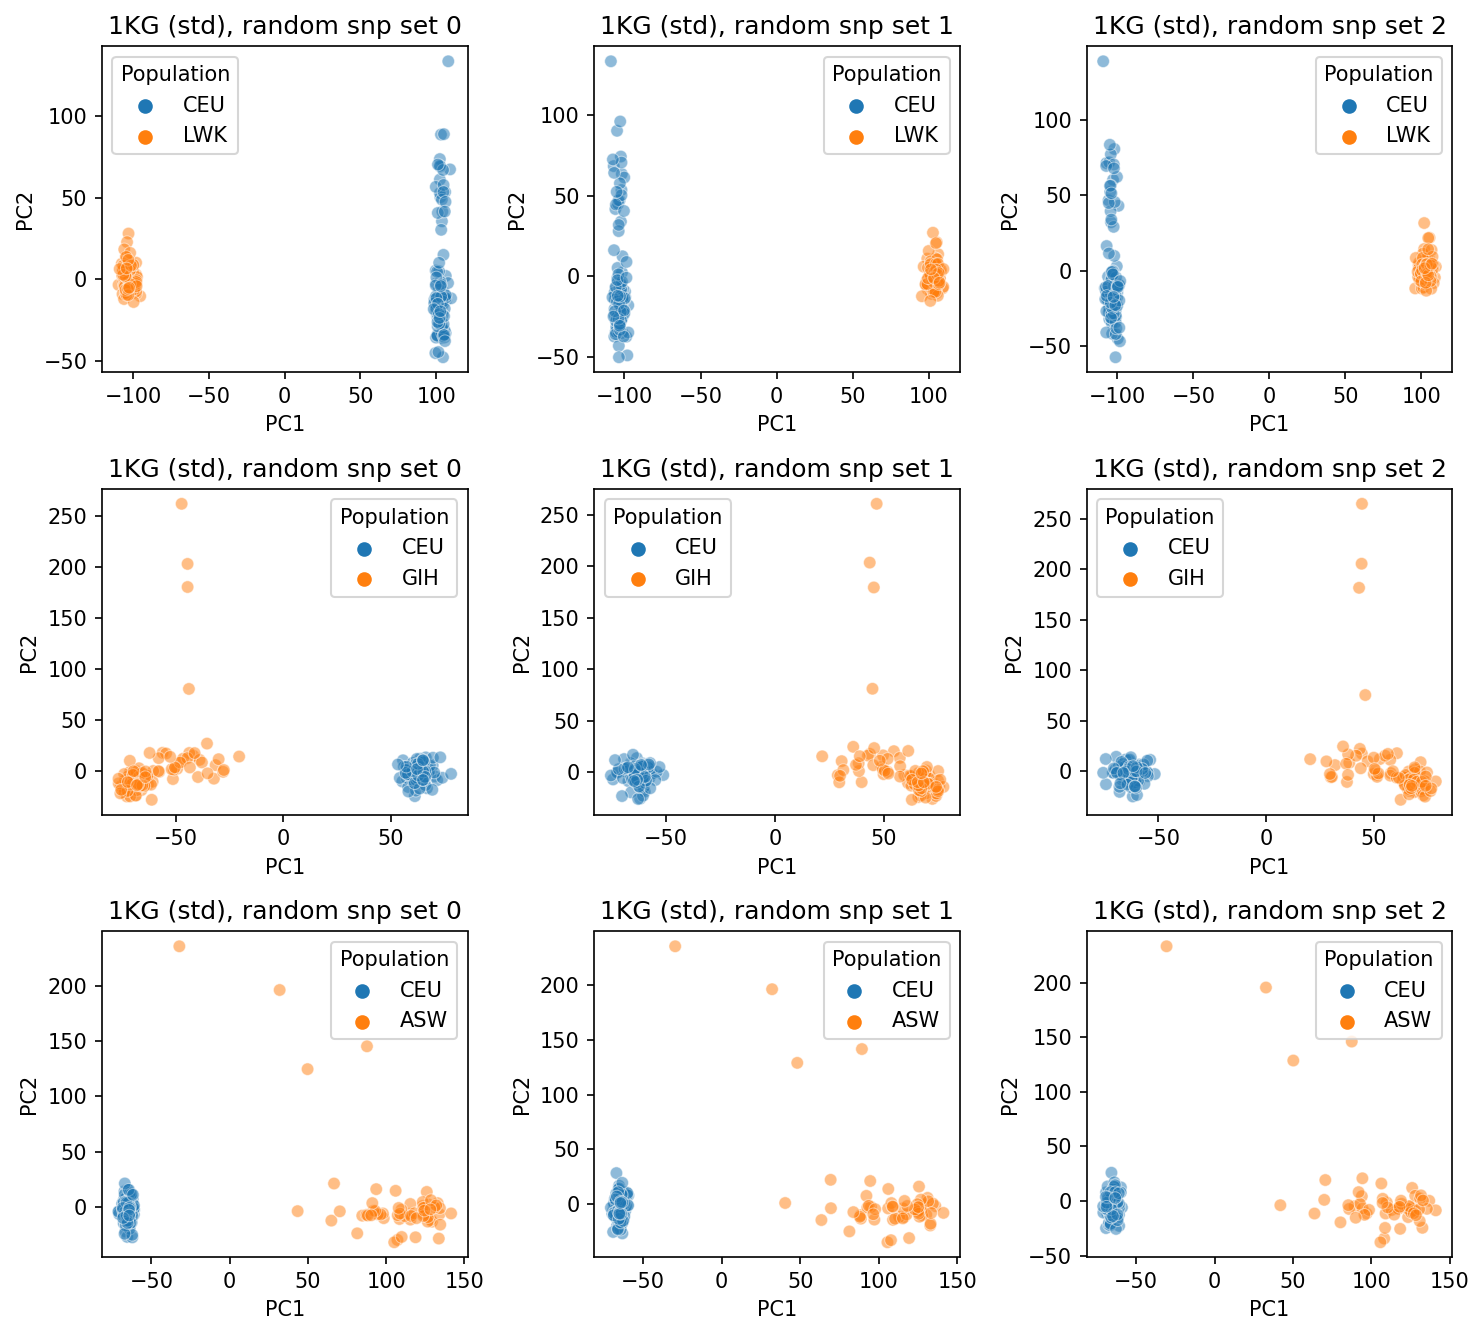

In [19]:
# Plot first two PCs

fig, axs = plt.subplots(3, 3, figsize =[10, 9])

for i, (name, data) in enumerate(pca_results.items()):
    
    snp_pca, df_snp_pca = data
    pops = name.split('_')[0].split('-')
    
    ax = fig.axes[i]
    sns.scatterplot(data=df_snp_pca.sample(frac=1), x="PC1", y="PC2", hue="Population", 
                    alpha=0.5, hue_order = pops, ax=ax)   
    seed = name.split('_')[1]
    ax.set_title(f'1KG (std), random snp set {seed}')
plt.tight_layout()

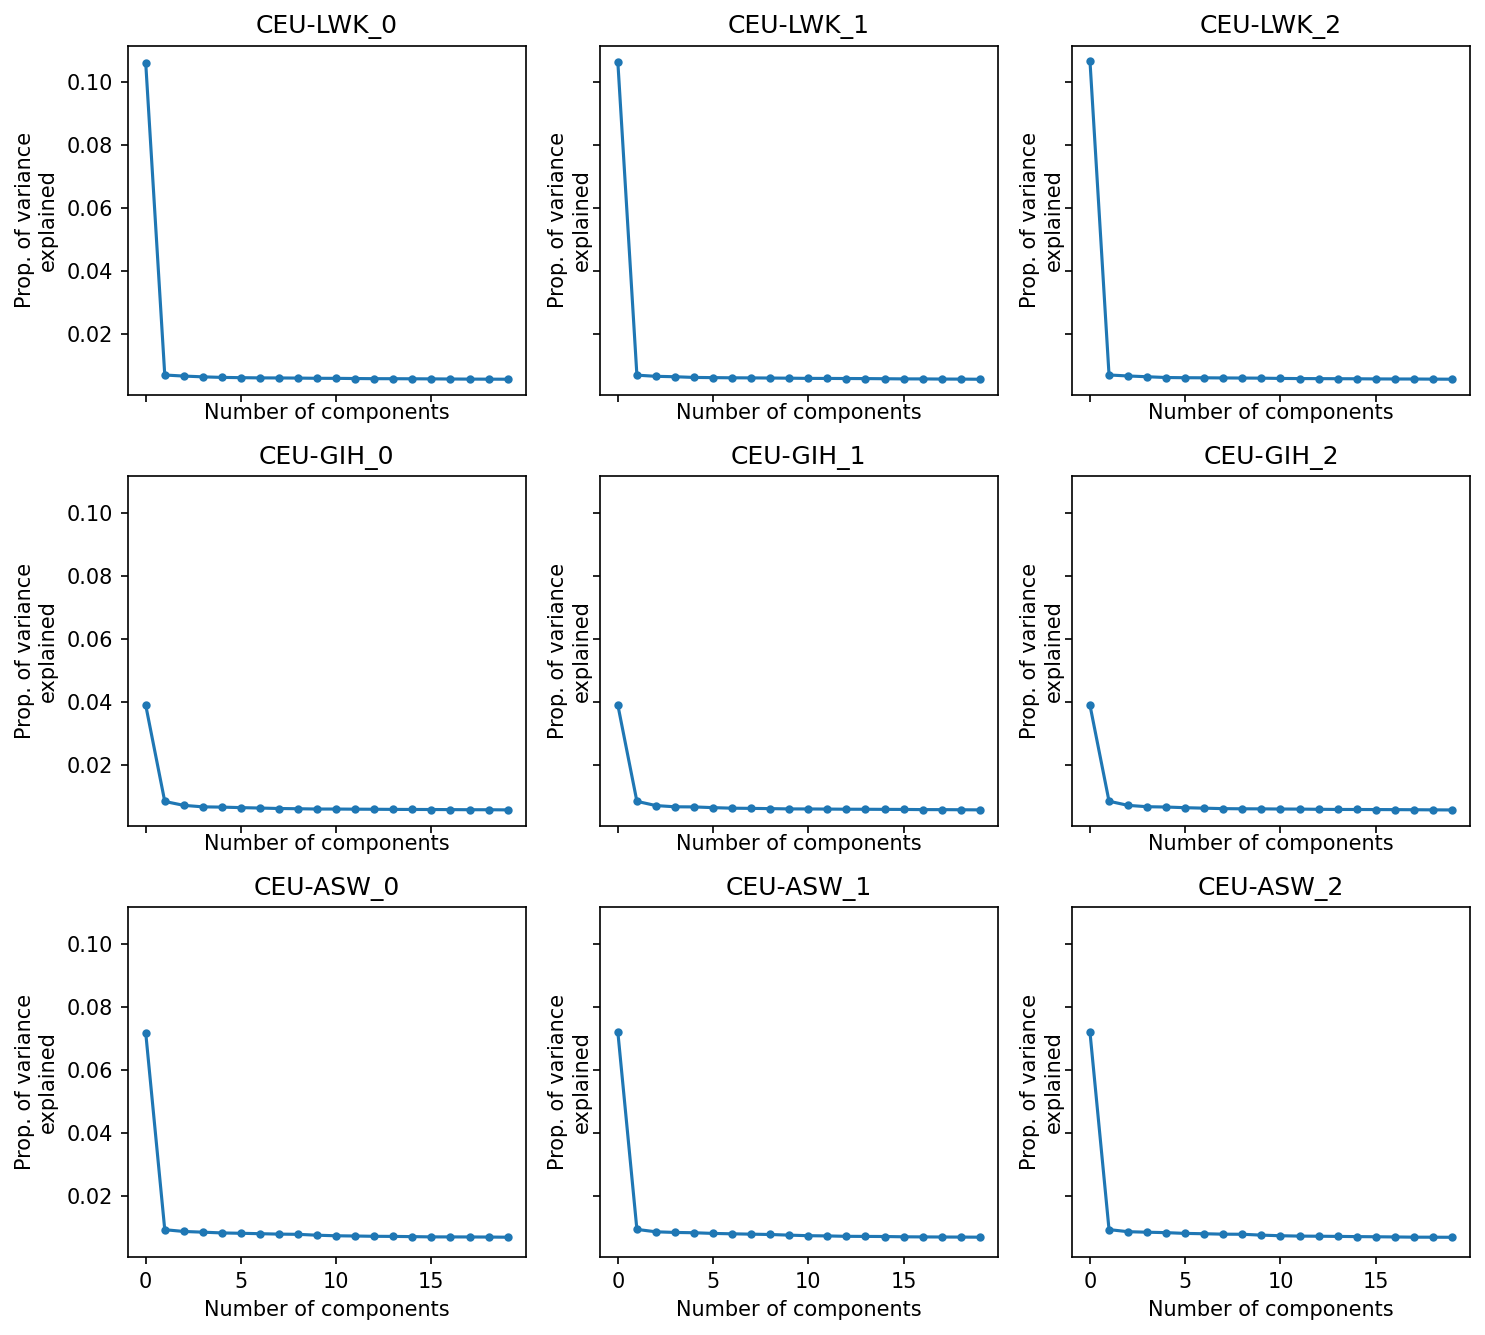

In [20]:
# Plot percentage variance explained as function of components

fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize =[10, 9])

for i, (name, data) in enumerate(pca_results.items()):
    
    snp_pca, df_snp_pca = data
    pops = name.split('_')[0].split('-')
    
    ax = fig.axes[i]
    ax.plot(snp_pca.explained_variance_ratio_, '.-')
    ax.set_xlabel('Number of components')
    ax.set_ylabel('Prop. of variance\nexplained')
    ax.set_title(name)
plt.tight_layout()

## NYGC PCA and visualization

In [21]:
# Similar plots for the NYGC ALS data
# First preprocess the metadata

nygc_metadata = df_als_metadata[df_als_metadata.source == 'NYGC']
nygc_strict_metadata = nygc_metadata[(nygc_metadata['Subject Group'] == 'Non-Neurological Control') | 
                                     (nygc_metadata['Subject Group Subcategory'] == 'Classical/Typical ALS')]

nygc_strict_metadata['y'] = (nygc_strict_metadata['Subject Group'] != 'Non-Neurological Control').astype('int64')

# also remove outlier
nygc_strict_metadata = nygc_strict_metadata[nygc_strict_metadata.ExternalSubjectId != 'NEUXT258BD4']

print(nygc_strict_metadata.y.value_counts())


1    2304
0     365
Name: y, dtype: int64


<ipython-input-21-31fbccad4a8f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nygc_strict_metadata['y'] = (nygc_strict_metadata['Subject Group'] != 'Non-Neurological Control').astype('int64')


In [22]:
def assign_super_pop(row, thresh1, thresh2):
    if row['pct_african'] > thresh1:
        pop = 'AFR'
    elif row['pct_european'] > thresh2:
        pop = 'EUR'
    elif row['pct_south_asian'] > thresh1:
        pop = 'SAS'
    else:
        pop = np.nan
        
    return pop


# Thresholds for assigning individuals to subpopulation categories
# Percent ancestry estimated using 1KG data
# Different hresholds set to promote more balanced subpopulation groups
pop_thresh = 0.8
pop_thresh_eu = 0.99
nygc_strict_metadata.super_pop = nygc_strict_metadata.apply(lambda row: assign_super_pop(row, pop_thresh, 
                                                                                         pop_thresh_eu),
                                                           axis=1)

<ipython-input-22-4ebc5d756a58>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nygc_strict_metadata.super_pop = nygc_strict_metadata.apply(lambda row: assign_super_pop(row, pop_thresh,


In [23]:
nygc_strict_metadata.super_pop.value_counts()

EUR    449
AFR     67
SAS     10
Name: super_pop, dtype: int64

In [24]:
%%time

# Compute PCA for relevant pairs of subpopulations in the NYGC ALS dataset
subpop_pairs = [['EUR', 'AFR'], ['EUR', 'SAS']]

pca_results_nygc = {}

for subpops in subpop_pairs:
    df_nygc_metadata_poppairs = nygc_strict_metadata[nygc_strict_metadata.super_pop.isin(subpops)]
    print(df_nygc_metadata_poppairs[['super_pop', 'y']].value_counts())
    
    for seed in range(3):
        np.random.seed(seed)
        inds_s = np.random.choice(valid_inds, size=subset_size, replace=False)

        # Subset sparse matrix
        sparse_x_sub = sparse_x_all[:, inds_s]
        sparse_x_sub = sparse_x_sub[df_nygc_metadata_poppairs.ind_val.values, :]
        print(sparse_x_sub.shape)
        
        pca_results_nygc[f'{"-".join(subpops)}_{seed}'] = compute_pcs_with_covar(sparse_x_sub.toarray(),
                                                                            df_nygc_metadata_poppairs,
                                                                            meta_columns = ['super_pop',
                                                                                            'y', 'ind_val',
                                                                                            'ExternalSubjectId'])

super_pop  y
EUR        1    374
           0     75
AFR        1     53
           0     14
dtype: int64
(516, 100000)
(516, 100000)
(516, 100000)
super_pop  y
EUR        1    374
           0     75
SAS        1     10
dtype: int64
(459, 100000)
(459, 100000)
(459, 100000)
CPU times: user 14min 19s, sys: 14min 27s, total: 28min 47s
Wall time: 3min 5s


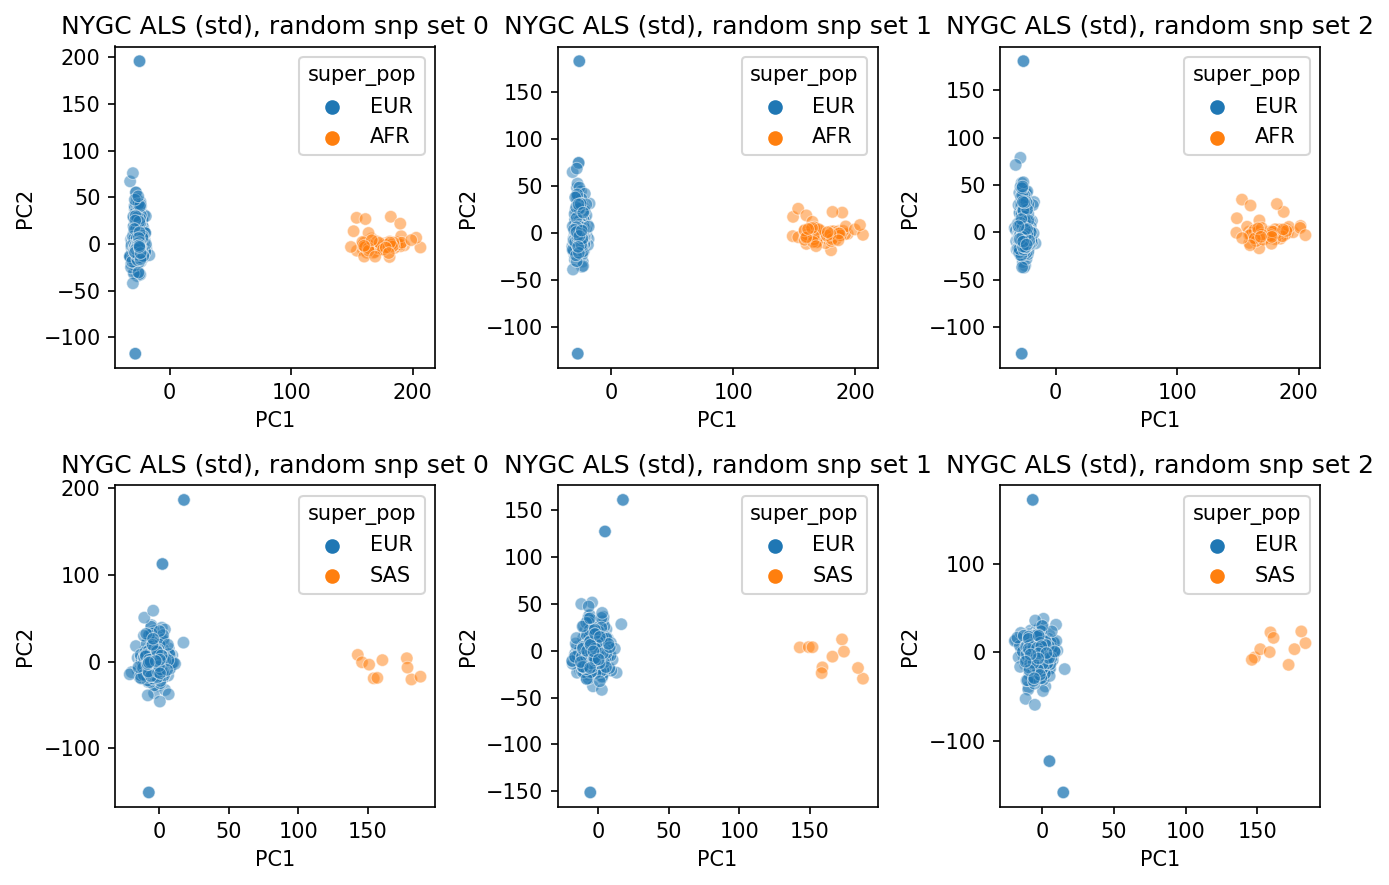

In [25]:
fig, axs = plt.subplots(2, 3, figsize =[9, 6])

for i, (name, data) in enumerate(pca_results_nygc.items()):
    
    snp_pca, df_snp_pca = data
    pops = name.split('_')[0].split('-')
    
    ax = fig.axes[i]
    sns.scatterplot(data=df_snp_pca.sample(frac=1), x="PC1", y="PC2", hue="super_pop", 
                    alpha=0.5, hue_order = pops, ax=ax)
    
    seed = name.split('_')[1]
    ax.set_title(f'NYGC ALS (std), random snp set {seed}')
plt.tight_layout()

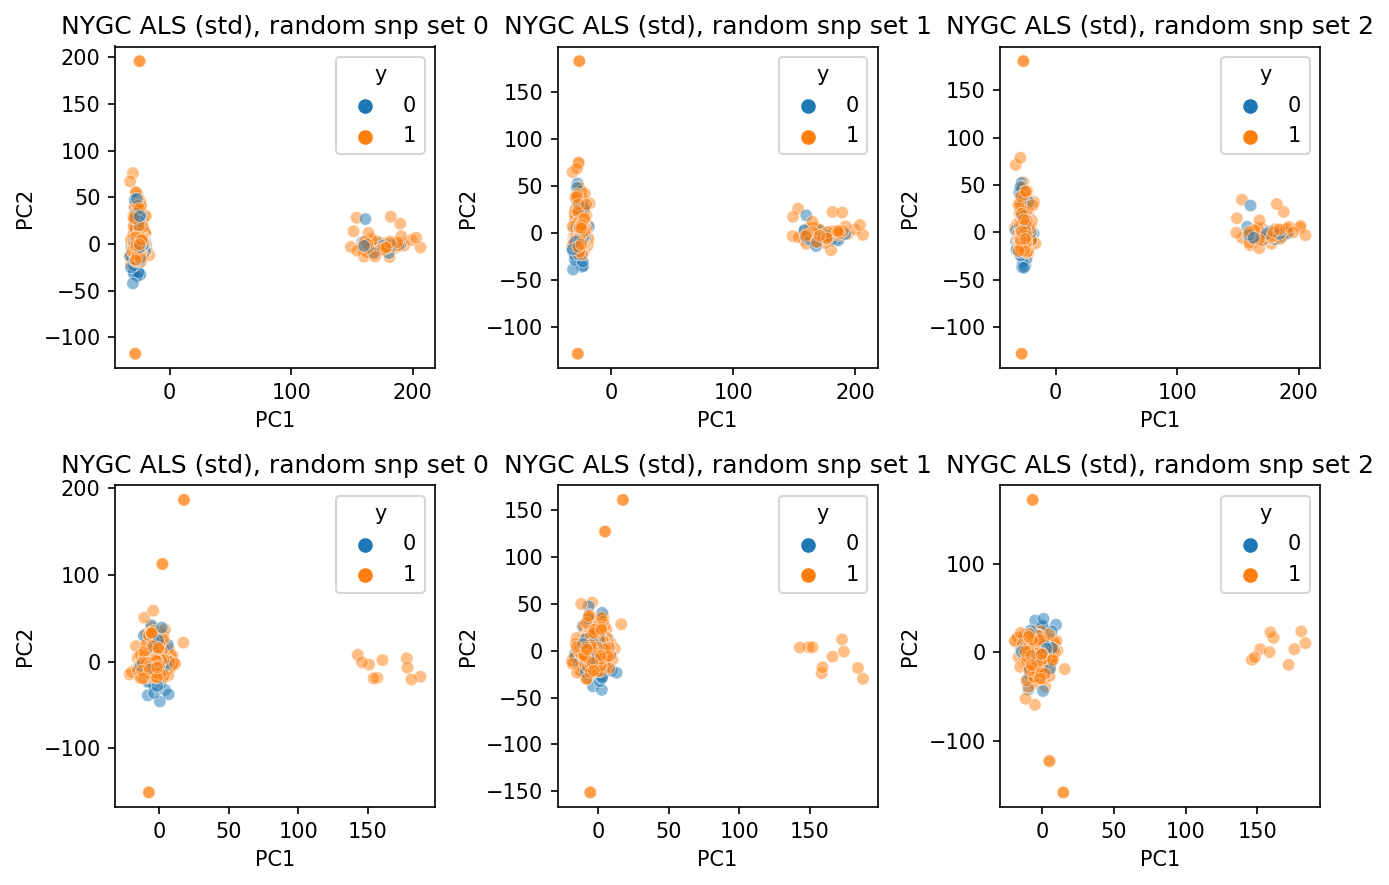

In [26]:
fig, axs = plt.subplots(2, 3, figsize =[9, 6])

for i, (name, data) in enumerate(pca_results_nygc.items()):
    
    snp_pca, df_snp_pca = data
    pops = name.split('_')[0].split('-')
    
    ax = fig.axes[i]
    sns.scatterplot(data=df_snp_pca.sample(frac=1), x="PC1", y="PC2", hue="y", 
                    alpha=0.5, hue_order = [0, 1], ax=ax)
    
    seed = name.split('_')[1]
    ax.set_title(f'NYGC ALS (std), random snp set {seed}')
plt.tight_layout()

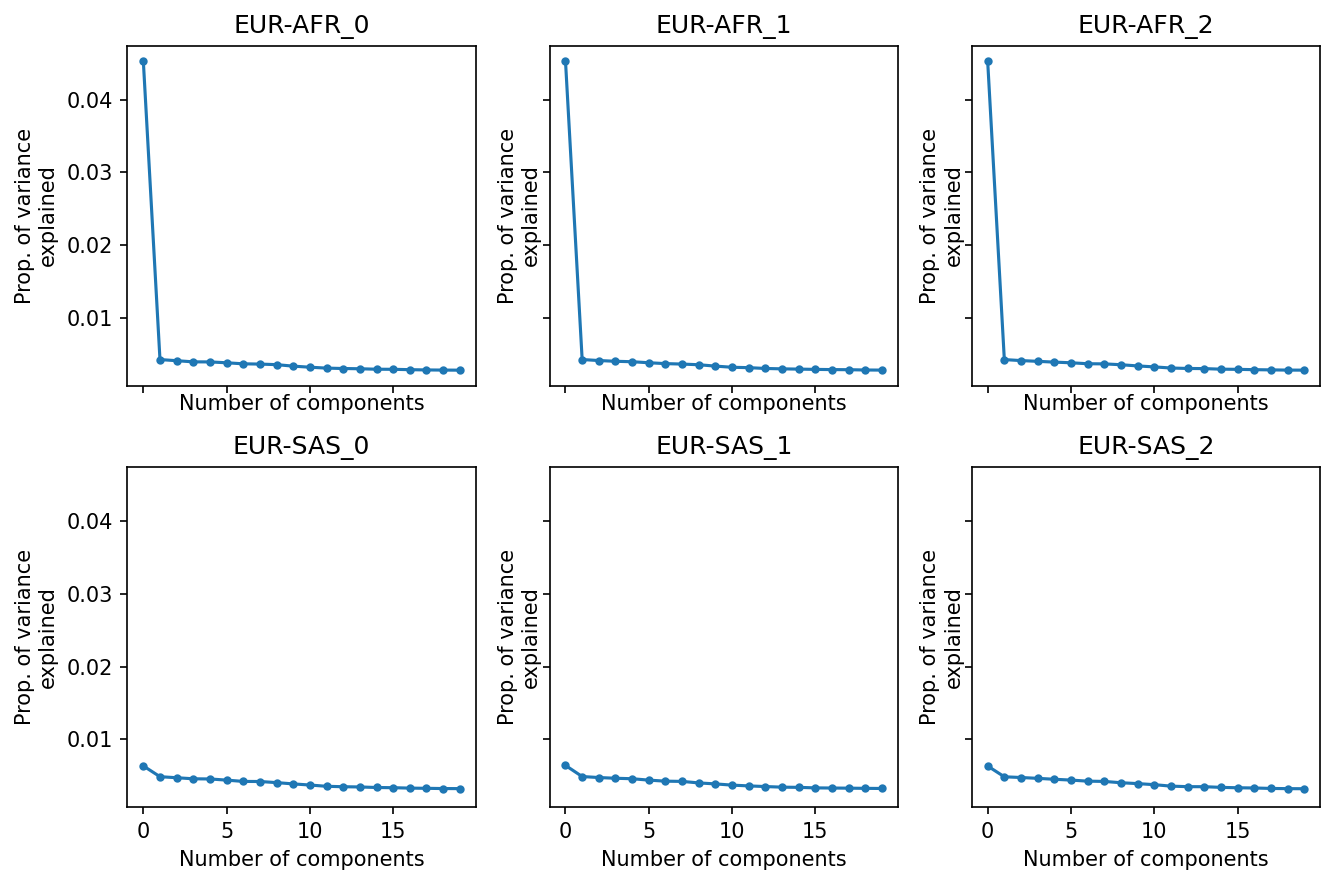

In [27]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize =[9, 6])

for i, (name, data) in enumerate(pca_results_nygc.items()):
    
    snp_pca, df_snp_pca = data
    pops = name.split('_')[0].split('-')
    
    ax = fig.axes[i]
    ax.plot(snp_pca.explained_variance_ratio_, '.-')
    ax.set_xlabel('Number of components')
    ax.set_ylabel('Prop. of variance\nexplained')
    ax.set_title(name)
plt.tight_layout()

### Outlier analysis

In [116]:
# there are a few outliers with respect to pc 2 in the european group 
# when first running PCA analysis -- these were removed in final plots shown
pca_results_nygc['EUR-AFR_0'][1].iloc[np.where(pca_results_nygc['EUR-AFR_0'][1].PC2 > 200)[0], :]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC15,PC16,PC17,PC18,PC19,PC20,super_pop,y,ind_val,ExternalSubjectId
206,-27.789748,302.361161,-0.107798,-9.687164,-0.983749,3.834952,-3.904719,-11.177176,-5.875015,6.455528,...,5.610351,-0.920459,-4.424372,5.877839,0.106242,-4.559753,EUR,1,3932,NEUXT258BD4
256,-27.770676,302.322058,-0.108647,-9.672163,-0.957619,3.860912,-3.869709,-11.186374,-5.853760,6.467913,...,5.589831,-0.886684,-4.404576,5.886847,0.132812,-4.559805,EUR,1,4365,NEUXT258BD4
434,-27.752885,302.357459,-0.130724,-9.637682,-1.018284,3.846383,-3.872077,-11.176731,-5.862153,6.452785,...,5.571304,-0.873055,-4.434328,5.865457,0.078404,-4.538253,EUR,1,5324,NEUXT258BD4


In [117]:
# this subject appears to be repeated, remove all samples
df_als_metadata[df_als_metadata.ExternalSubjectId == 'NEUXT258BD4']

,subject_id.1,ExternalSampleId,ExternalSubjectId,Project,Site Sample Collected,Site Specimen Collected,Sex,Ethnicity,Subject Group,Subject Group Subcategory,...,pct_european,pct_americas,source,Family ID,Gender,Phenotype,Population,super_pop,y,ind_val
subject_id,,,,,,,,,,,,,,,,,,,,,
CGND-HDA-01469,CGND-HDA-01469,CGND-HDA-01469,NEUXT258BD4,ALS Consortium,"Columbia University Medical Center, CUMC (PI: ...",Columbia University Medical Center,Female,Not Hispanic or Latino,ALS Spectrum MND,Classical/Typical ALS,...,0.991815,0.00001,NYGC,NaN,NaN,NaN,NaN,NaN,1,3932
CGND-HDA-00946,CGND-HDA-00946,CGND-HDA-00946,NEUXT258BD4,ALS Consortium,"Columbia University Medical Center, CUMC (PI: ...",Columbia University Medical Center,Female,Not Hispanic or Latino,ALS Spectrum MND,Classical/Typical ALS,...,0.991815,0.00001,NYGC,NaN,NaN,NaN,NaN,NaN,1,4365
NEUXT258BD4,NEUXT258BD4,CGND-HDA-00168,NEUXT258BD4,Target ALS,"Columbia University Medical Center, CUMC (PI: ...",Columbia University Medical Center,Female,Not Hispanic or Latino,ALS Spectrum MND,Classical/Typical ALS,...,0.991815,0.00001,NYGC,NaN,NaN,NaN,NaN,NaN,1,5324


## Saving data for NYGC

10 random SNP sets for each pair of populations + 1 most variable SNP set

In [30]:
data_dir = '/scratch/users/velina/sparse_nn/ltsim/data/als/'

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

In [39]:
# get SNP names
full_snp_df = pd.read_csv('/scratch/users/velina/sparse_nn/eqtl_sparse_snps_df.csv', index_col=0)
full_snp_df.reset_index(inplace=True)
full_snp_df

,index,chr,position_x,ref,alt,new_snp_id
0,0,chr1,992361,G,A,1:992361
1,1,chr1,994997,C,T,1:994997
2,2,chr1,996168,G,T,1:996168
3,3,chr1,1002745,G,A,1:1002745
4,4,chr1,1025029,G,C,1:1025029
...,...,...,...,...,...,...
1202389,22617,chr22,50779796,C,A,22:50779796
1202390,22618,chr22,50779949,G,C,22:50779949
1202391,22619,chr22,50780578,G,A,22:50780578
1202392,22620,chr22,50781276,G,A,22:50781276


In [45]:
%%time

for subpops in subpop_pairs:
    df_nygc_metadata_poppairs = nygc_strict_metadata[nygc_strict_metadata.super_pop.isin(subpops)]
    pop_name = '-'.join(subpops)
    print(df_nygc_metadata_poppairs[['super_pop', 'y']].value_counts())
    
    for seed in range(10):
        np.random.seed(seed)
        inds_s = np.random.choice(valid_inds, size=subset_size, replace=False)

        # Subset sparse matrix
        sparse_x_sub = sparse_x_all[:, inds_s]
        sparse_x_sub = sparse_x_sub[df_nygc_metadata_poppairs.ind_val.values, :]
        print(sparse_x_sub.shape)
        
        x_sub_df = pd.DataFrame(sparse_x_sub.toarray())
        x_sub_df.columns = full_snp_df.loc[inds_s, 'new_snp_id'].values
        x_sub_df.index = df_nygc_metadata_poppairs.ExternalSampleId.values
        display(x_sub_df.head())
        
#         x_sub_df.T.to_csv(f'{data_dir}{pop_name}_rand_subset_{subset_size}_snps_{seed}.csv.gz', compression='gzip')
    

super_pop  y
EUR        1    374
           0     75
AFR        1     53
           0     14
dtype: int64
(516, 100000)


,4:77811424,2:149131277,16:84098870,22:39102694,7:12882549,5:141653094,14:104372424,19:52911775,12:132702048,11:45298430,...,1:160063761,2:172441412,21:44290645,17:43398087,13:24562394,10:120992953,16:88543922,20:32032518,2:238360356,3:161180384
CGND-HDA-00604,1.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0
CGND-HDA-00237,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
CGND-HDA-02221,2.0,2.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
CGND-HDA-03842,1.0,2.0,0.0,0.0,0.0,2.0,1.0,0.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CGND-HDA-03834,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0


(516, 100000)


,4:149210074,4:4526831,13:24363047,2:206839559,3:101309911,8:10277893,1:219309698,3:159967905,17:59667313,14:65284804,...,2:229018412,5:180531984,8:86545129,17:76614269,13:94802732,18:11989970,6:85363770,6:35503233,1:58663973,2:202940311
CGND-HDA-00604,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,2.0
CGND-HDA-00237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0
CGND-HDA-02221,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,2.0,2.0,0.0,1.0,2.0
CGND-HDA-03842,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,1.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0
CGND-HDA-03834,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0


(516, 100000)


,7:43744015,19:27868610,7:124065122,20:45791469,16:74525219,8:103423506,11:86484915,1:64186812,18:43242703,7:16058530,...,10:62394445,10:62781150,18:62174474,4:26850226,2:61814489,4:26968236,1:20575429,12:38950641,12:26760014,19:53280989
CGND-HDA-00604,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
CGND-HDA-00237,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,...,1.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
CGND-HDA-02221,0.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0,1.0,2.0,...,2.0,1.0,1.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0
CGND-HDA-03842,0.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,1.0,2.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
CGND-HDA-03834,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,...,1.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0


(516, 100000)


,12:48967271,7:124125745,2:148003058,7:93596462,3:155724964,9:89587808,11:18542633,1:24821800,3:170938831,12:48949761,...,11:96759840,6:152809396,2:128062662,2:177652543,1:61706536,11:50184444,2:30533795,22:39122310,8:11133162,8:101993263
CGND-HDA-00604,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0
CGND-HDA-00237,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0
CGND-HDA-02221,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
CGND-HDA-03842,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,...,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0
CGND-HDA-03834,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


(516, 100000)


,6:96587542,10:95186887,11:50574212,7:42655592,6:170494093,6:132738375,2:99130656,16:1803334,2:171101238,11:49353469,...,18:45779159,1:19544860,2:72434662,15:26861902,5:77734582,5:127271240,14:31814994,7:65391320,17:41182128,11:7857293
CGND-HDA-00604,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,...,2.0,0.0,2.0,1.0,2.0,2.0,1.0,0.0,2.0,0.0
CGND-HDA-00237,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0
CGND-HDA-02221,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,2.0,1.0
CGND-HDA-03842,1.0,2.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,...,2.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,2.0,1.0
CGND-HDA-03834,0.0,2.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,2.0,1.0


(516, 100000)


,14:32738857,12:49199594,10:19840701,5:144176045,17:82152874,4:118298086,16:68782357,1:184185544,1:67905931,2:43630980,...,4:129188461,12:21433265,10:50612935,8:12008629,3:21338773,2:111869524,4:143762982,2:85531667,2:85416771,4:185218752
CGND-HDA-00604,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0,0.0,2.0
CGND-HDA-00237,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0
CGND-HDA-02221,1.0,0.0,1.0,0.0,2.0,0.0,1.0,2.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,2.0
CGND-HDA-03842,1.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0
CGND-HDA-03834,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,2.0,1.0,1.0,2.0,0.0,1.0,0.0,1.0


(516, 100000)


,1:169759134,16:11201540,15:42121686,2:218544966,11:47634200,1:231451220,2:202997231,1:46075886,13:30942273,1:248332830,...,12:61768819,12:110623847,6:166381248,19:56359088,9:92032640,10:70327142,16:11823489,10:126005555,1:155220491,8:9716767
CGND-HDA-00604,0.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,2.0,...,1.0,1.0,2.0,0.0,0.0,0.0,2.0,1.0,0.0,2.0
CGND-HDA-00237,0.0,0.0,2.0,2.0,1.0,0.0,1.0,1.0,1.0,2.0,...,2.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0
CGND-HDA-02221,0.0,1.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,...,2.0,0.0,2.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0
CGND-HDA-03842,0.0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,2.0,...,0.0,1.0,2.0,0.0,0.0,0.0,2.0,2.0,0.0,1.0
CGND-HDA-03834,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0


(516, 100000)


,6:96977219,4:186438451,15:32807828,2:55486345,1:15988369,14:104945363,8:10869730,11:4145756,6:169435906,6:768576,...,9:91237559,9:128857150,17:18644693,7:57457203,7:48858556,2:85684554,14:20335005,17:75550243,17:47338411,11:6834237
CGND-HDA-00604,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
CGND-HDA-00237,1.0,0.0,1.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,2.0,0.0,0.0
CGND-HDA-02221,0.0,0.0,0.0,2.0,0.0,2.0,1.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,1.0
CGND-HDA-03842,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
CGND-HDA-03834,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,1.0,0.0,...,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0


(516, 100000)


,15:84901463,2:241136873,17:29729594,6:46079397,6:168328279,22:30503421,17:6645160,16:53480938,7:65626193,19:51011181,...,12:72276522,3:20456876,2:139428401,5:71552955,16:1431796,22:29773882,3:141975255,15:34182998,14:73959969,3:55864822
CGND-HDA-00604,0.0,1.0,1.0,0.0,0.0,2.0,2.0,0.0,2.0,2.0,...,0.0,1.0,1.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0
CGND-HDA-00237,1.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,...,0.0,2.0,1.0,0.0,2.0,0.0,1.0,1.0,2.0,0.0
CGND-HDA-02221,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,1.0,...,0.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,0.0
CGND-HDA-03842,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,2.0,2.0,...,0.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0
CGND-HDA-03834,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,...,1.0,2.0,2.0,2.0,1.0,0.0,1.0,1.0,1.0,0.0


(516, 100000)


,3:168128760,19:53091043,13:37080794,15:53096267,4:48264785,4:527712,7:67437140,1:174727931,1:28339065,5:72854032,...,8:17927749,20:45480797,9:104608033,10:102467077,18:15081672,19:48719762,17:8329963,10:27216988,18:53221586,9:99895391
CGND-HDA-00604,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
CGND-HDA-00237,0.0,1.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
CGND-HDA-02221,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,2.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,0.0,2.0
CGND-HDA-03842,1.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
CGND-HDA-03834,1.0,0.0,2.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0,2.0


super_pop  y
EUR        1    374
           0     75
SAS        1     10
dtype: int64
(459, 100000)


,4:77811424,2:149131277,16:84098870,22:39102694,7:12882549,5:141653094,14:104372424,19:52911775,12:132702048,11:45298430,...,1:160063761,2:172441412,21:44290645,17:43398087,13:24562394,10:120992953,16:88543922,20:32032518,2:238360356,3:161180384
CGND-HDA-00237,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
CGND-HDA-02221,2.0,2.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
CGND-HDA-03834,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
CGND-HDA-03141,2.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,...,2.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0
CGND-HDA-02236,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


(459, 100000)


,4:149210074,4:4526831,13:24363047,2:206839559,3:101309911,8:10277893,1:219309698,3:159967905,17:59667313,14:65284804,...,2:229018412,5:180531984,8:86545129,17:76614269,13:94802732,18:11989970,6:85363770,6:35503233,1:58663973,2:202940311
CGND-HDA-00237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0
CGND-HDA-02221,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,2.0,2.0,0.0,1.0,2.0
CGND-HDA-03834,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0
CGND-HDA-03141,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,...,2.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0
CGND-HDA-02236,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,...,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0


(459, 100000)


,7:43744015,19:27868610,7:124065122,20:45791469,16:74525219,8:103423506,11:86484915,1:64186812,18:43242703,7:16058530,...,10:62394445,10:62781150,18:62174474,4:26850226,2:61814489,4:26968236,1:20575429,12:38950641,12:26760014,19:53280989
CGND-HDA-00237,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,...,1.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
CGND-HDA-02221,0.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0,1.0,2.0,...,2.0,1.0,1.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0
CGND-HDA-03834,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,...,1.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0
CGND-HDA-03141,1.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
CGND-HDA-02236,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,...,2.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,0.0


(459, 100000)


,12:48967271,7:124125745,2:148003058,7:93596462,3:155724964,9:89587808,11:18542633,1:24821800,3:170938831,12:48949761,...,11:96759840,6:152809396,2:128062662,2:177652543,1:61706536,11:50184444,2:30533795,22:39122310,8:11133162,8:101993263
CGND-HDA-00237,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0
CGND-HDA-02221,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
CGND-HDA-03834,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
CGND-HDA-03141,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,1.0
CGND-HDA-02236,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,2.0,1.0,0.0,0.0,0.0,2.0,2.0,1.0,2.0


(459, 100000)


,6:96587542,10:95186887,11:50574212,7:42655592,6:170494093,6:132738375,2:99130656,16:1803334,2:171101238,11:49353469,...,18:45779159,1:19544860,2:72434662,15:26861902,5:77734582,5:127271240,14:31814994,7:65391320,17:41182128,11:7857293
CGND-HDA-00237,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0
CGND-HDA-02221,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,2.0,1.0
CGND-HDA-03834,0.0,2.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,2.0,1.0
CGND-HDA-03141,0.0,1.0,2.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,2.0,0.0
CGND-HDA-02236,0.0,0.0,2.0,1.0,1.0,2.0,0.0,1.0,1.0,0.0,...,2.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0


(459, 100000)


,14:32738857,12:49199594,10:19840701,5:144176045,17:82152874,4:118298086,16:68782357,1:184185544,1:67905931,2:43630980,...,4:129188461,12:21433265,10:50612935,8:12008629,3:21338773,2:111869524,4:143762982,2:85531667,2:85416771,4:185218752
CGND-HDA-00237,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0
CGND-HDA-02221,1.0,0.0,1.0,0.0,2.0,0.0,1.0,2.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,2.0
CGND-HDA-03834,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,2.0,1.0,1.0,2.0,0.0,1.0,0.0,1.0
CGND-HDA-03141,1.0,2.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,...,1.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0
CGND-HDA-02236,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0


(459, 100000)


,1:169759134,16:11201540,15:42121686,2:218544966,11:47634200,1:231451220,2:202997231,1:46075886,13:30942273,1:248332830,...,12:61768819,12:110623847,6:166381248,19:56359088,9:92032640,10:70327142,16:11823489,10:126005555,1:155220491,8:9716767
CGND-HDA-00237,0.0,0.0,2.0,2.0,1.0,0.0,1.0,1.0,1.0,2.0,...,2.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0
CGND-HDA-02221,0.0,1.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,...,2.0,0.0,2.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0
CGND-HDA-03834,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0
CGND-HDA-03141,0.0,1.0,2.0,2.0,0.0,1.0,0.0,2.0,1.0,2.0,...,0.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0
CGND-HDA-02236,0.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0


(459, 100000)


,6:96977219,4:186438451,15:32807828,2:55486345,1:15988369,14:104945363,8:10869730,11:4145756,6:169435906,6:768576,...,9:91237559,9:128857150,17:18644693,7:57457203,7:48858556,2:85684554,14:20335005,17:75550243,17:47338411,11:6834237
CGND-HDA-00237,1.0,0.0,1.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,2.0,0.0,0.0
CGND-HDA-02221,0.0,0.0,0.0,2.0,0.0,2.0,1.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,1.0
CGND-HDA-03834,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,1.0,0.0,...,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0
CGND-HDA-03141,0.0,1.0,0.0,2.0,0.0,2.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
CGND-HDA-02236,1.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


(459, 100000)


,15:84901463,2:241136873,17:29729594,6:46079397,6:168328279,22:30503421,17:6645160,16:53480938,7:65626193,19:51011181,...,12:72276522,3:20456876,2:139428401,5:71552955,16:1431796,22:29773882,3:141975255,15:34182998,14:73959969,3:55864822
CGND-HDA-00237,1.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,...,0.0,2.0,1.0,0.0,2.0,0.0,1.0,1.0,2.0,0.0
CGND-HDA-02221,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,1.0,...,0.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,0.0
CGND-HDA-03834,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,...,1.0,2.0,2.0,2.0,1.0,0.0,1.0,1.0,1.0,0.0
CGND-HDA-03141,2.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,2.0,2.0,2.0,1.0,0.0,1.0,2.0,0.0
CGND-HDA-02236,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,2.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0


(459, 100000)


,3:168128760,19:53091043,13:37080794,15:53096267,4:48264785,4:527712,7:67437140,1:174727931,1:28339065,5:72854032,...,8:17927749,20:45480797,9:104608033,10:102467077,18:15081672,19:48719762,17:8329963,10:27216988,18:53221586,9:99895391
CGND-HDA-00237,0.0,1.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
CGND-HDA-02221,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,2.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,0.0,2.0
CGND-HDA-03834,1.0,0.0,2.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0,2.0
CGND-HDA-03141,0.0,2.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0,2.0
CGND-HDA-02236,1.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0


CPU times: user 1h 15min 29s, sys: 2min 13s, total: 1h 17min 42s
Wall time: 1h 17min 40s


In [44]:
%%time
# saving y vectors

for subpops in subpop_pairs:
    df_nygc_metadata_poppairs = nygc_strict_metadata[nygc_strict_metadata.super_pop.isin(subpops)]
    pop_name = '-'.join(subpops)
    print(df_nygc_metadata_poppairs[['super_pop', 'y']].value_counts())
    
    y_labeled = df_nygc_metadata_poppairs[['y']]
    y_labeled.columns = ['label1']
    y_labeled.label1 = y_labeled.label1 + 1
    y_labeled.index = df_nygc_metadata_poppairs.ExternalSampleId.values
    
    display(y_labeled.head())
    
#     y_labeled.to_csv(f'{data_dir}{pop_name}_y_labeled.csv')

super_pop  y
EUR        1    374
           0     75
AFR        1     53
           0     14
dtype: int64


<timed exec>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,label1
CGND-HDA-00604,2
CGND-HDA-00237,2
CGND-HDA-02221,2
CGND-HDA-03842,2
CGND-HDA-03834,2


super_pop  y
EUR        1    374
           0     75
SAS        1     10
dtype: int64


<timed exec>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,label1
CGND-HDA-00237,2
CGND-HDA-02221,2
CGND-HDA-03834,2
CGND-HDA-03141,2
CGND-HDA-02236,2


CPU times: user 87.4 ms, sys: 28.7 ms, total: 116 ms
Wall time: 204 ms


In [46]:
# Also save most variable snps files

for subpops in subpop_pairs:
    df_nygc_metadata_poppairs = nygc_strict_metadata[nygc_strict_metadata.super_pop.isin(subpops)]
    pop_name = '-'.join(subpops)
    print(df_nygc_metadata_poppairs[['super_pop', 'y']].value_counts())
    
    # Subset to most variable snps
    sparse_x_sub = sparse_x_all[:, top_var]
    sparse_x_sub = sparse_x_sub[df_nygc_metadata_poppairs.ind_val.values, :]
    print(sparse_x_sub.shape)
    
    x_sub_df = pd.DataFrame(sparse_x_sub.toarray())
    x_sub_df.columns = full_snp_df.loc[top_var, 'new_snp_id'].values
    x_sub_df.index = df_nygc_metadata_poppairs.ExternalSampleId.values
    display(x_sub_df.head())
    
#     x_sub_df.T.to_csv(f'{data_dir}{pop_name}_most_var_subset_{subset_size}_snps.csv.gz', compression='gzip')    

super_pop  y
EUR        1    374
           0     75
AFR        1     53
           0     14
dtype: int64
(516, 100000)


,1:109692410,1:109690625,17:41274065,22:23941329,11:28986580,11:1994605,22:23933971,22:18905735,7:28174995,17:41268565,...,2:190363154,2:190363152,11:693787,6:47543891,6:47541209,6:47556442,10:42838378,12:118760721,2:98158655,9:19238243
CGND-HDA-00604,2.0,2.0,2.0,2.0,0.0,0.0,2.0,1.0,2.0,2.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
CGND-HDA-00237,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,...,2.0,2.0,0.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0
CGND-HDA-02221,2.0,2.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0
CGND-HDA-03842,2.0,2.0,2.0,2.0,0.0,1.0,2.0,2.0,2.0,2.0,...,1.0,1.0,0.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0
CGND-HDA-03834,0.0,0.0,0.0,2.0,0.0,2.0,2.0,2.0,0.0,0.0,...,0.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0


super_pop  y
EUR        1    374
           0     75
SAS        1     10
dtype: int64
(459, 100000)


,1:109692410,1:109690625,17:41274065,22:23941329,11:28986580,11:1994605,22:23933971,22:18905735,7:28174995,17:41268565,...,2:190363154,2:190363152,11:693787,6:47543891,6:47541209,6:47556442,10:42838378,12:118760721,2:98158655,9:19238243
CGND-HDA-00237,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,...,2.0,2.0,0.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0
CGND-HDA-02221,2.0,2.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0
CGND-HDA-03834,0.0,0.0,0.0,2.0,0.0,2.0,2.0,2.0,0.0,0.0,...,0.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
CGND-HDA-03141,0.0,0.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0,2.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0
CGND-HDA-02236,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
